## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


For example:

```python
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    

```


```python
def get_data(args1, *args):
    ....
    ....
    return train_loader, test_loader
```

# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


In [1]:
import os
import time
import torch
import pandas as pd
from skimage import io, transform
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms, utils, models
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from dataclasses import dataclass
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from torch.optim import lr_scheduler
import torch.optim as optim

In [3]:
def configureSystem():
    '''
    Describes the common system setting needed for reproducible training
    '''
    torch.manual_seed(21)
    if torch.cuda.is_available():
        device = torch.device("cuda:1")
        torch.backends.cudnn_benchmark_enabled = True
        torch.backends.cudnn.deterministic = True

In [4]:
class KenyanFood13Dataset(Dataset):
    """

    """
        
    def __init__(self, csv_file, root_dir, suffix, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root = root_dir
        self.suffix = suffix
        self.transform = transform
        self.classes = list(self.data['class'].unique())

    def __getitem__(self, idx):
        img_name = os.path.join(self.root, str(self.data.iloc[idx, 0]) + self.suffix)
        
        image = Image.open(img_name)
        
        # String target
        # target = self.data.iloc[idx, 1]
        
        # target as id (0,1,2,3...12)
        target = self.class_to_index(self.data.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, target
    
    
    def class_to_index(self, class_name):
        return self.classes.index(class_name)
    
    
    def index_to_class(self, class_index):
        return self.classes[class_index]
    
    
    def __len__(self):
        return len(self.data)


In [5]:
# Used to apply transforms to training and validation data
class KenyanFood13Subset(KenyanFood13Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform


    def __getitem__(self, idx):
        img, target = self.subset[idx]
        if self.transform:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.subset)

In [6]:
# Used to make predictions
class KenyanFood13Testset(Dataset):
    def __init__(self, csv_file, root_dir, suffix, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root = root_dir
        self.suffix = suffix
        self.transform = transform


    def __getitem__(self, idx):
        img_name = os.path.join(self.root, str(self.data.iloc[idx, 0]) + self.suffix)
        
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image
    
    def __len__(self):
        return len(self.data)

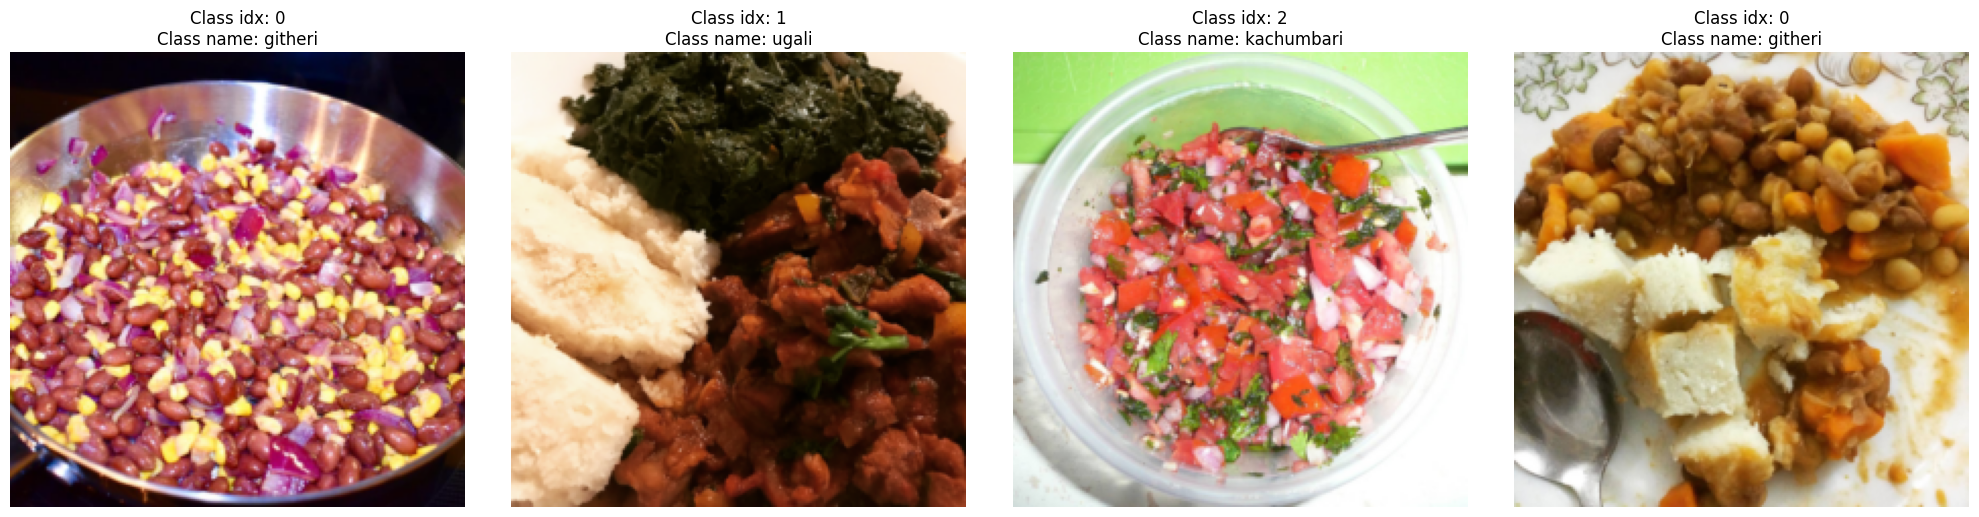

In [7]:
# Testing Dataset
data_path = '/kaggle/input/opencv-pytorch-classification-project-2/images/images'
csv_path = '/kaggle/input/opencv-pytorch-classification-project-2/train.csv'

dataset = KenyanFood13Dataset(csv_file=csv_path,
                                       root_dir=data_path,
                                       suffix='.jpg',
                                       transform=transforms.Compose([
                                           transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           ]))

plt.figure(figsize=(20,15))

for i in range(len(dataset)):
    img, label = dataset[i]
    ax = plt.subplot(1, 4, i % 4 + 1)  # Ensures valid subplot numbering
    plt.tight_layout()
    ax.set_title(f'Class idx: {label}\nClass name: {dataset.index_to_class(label)}')
    ax.axis('off')
    plt.imshow(img)
    if i % 4 == 3:  # Show the plot after every 4 images
        plt.show()
        break

In [8]:
def get_mean_std(dataset, num_workers=4):

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor()
        ])
    
    loader = DataLoader(dataset, batch_size=10, shuffle=False, num_workers=2)

    mean = 0.
    std = 0.
    
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std


Data Augmentation is turned ON!
Training Data: 5228
Validation Data: 1308
Number of classes: 13

Data per class (before split):
class
chapati        862
nyamachoma     784
bhaji          632
ugali          628
mandazi        620
kachumbari     494
matoke         483
githeri        479
masalachips    438
sukumawiki     402
pilau          329
mukimo         212
kukuchoma      173
Name: count, dtype: int64


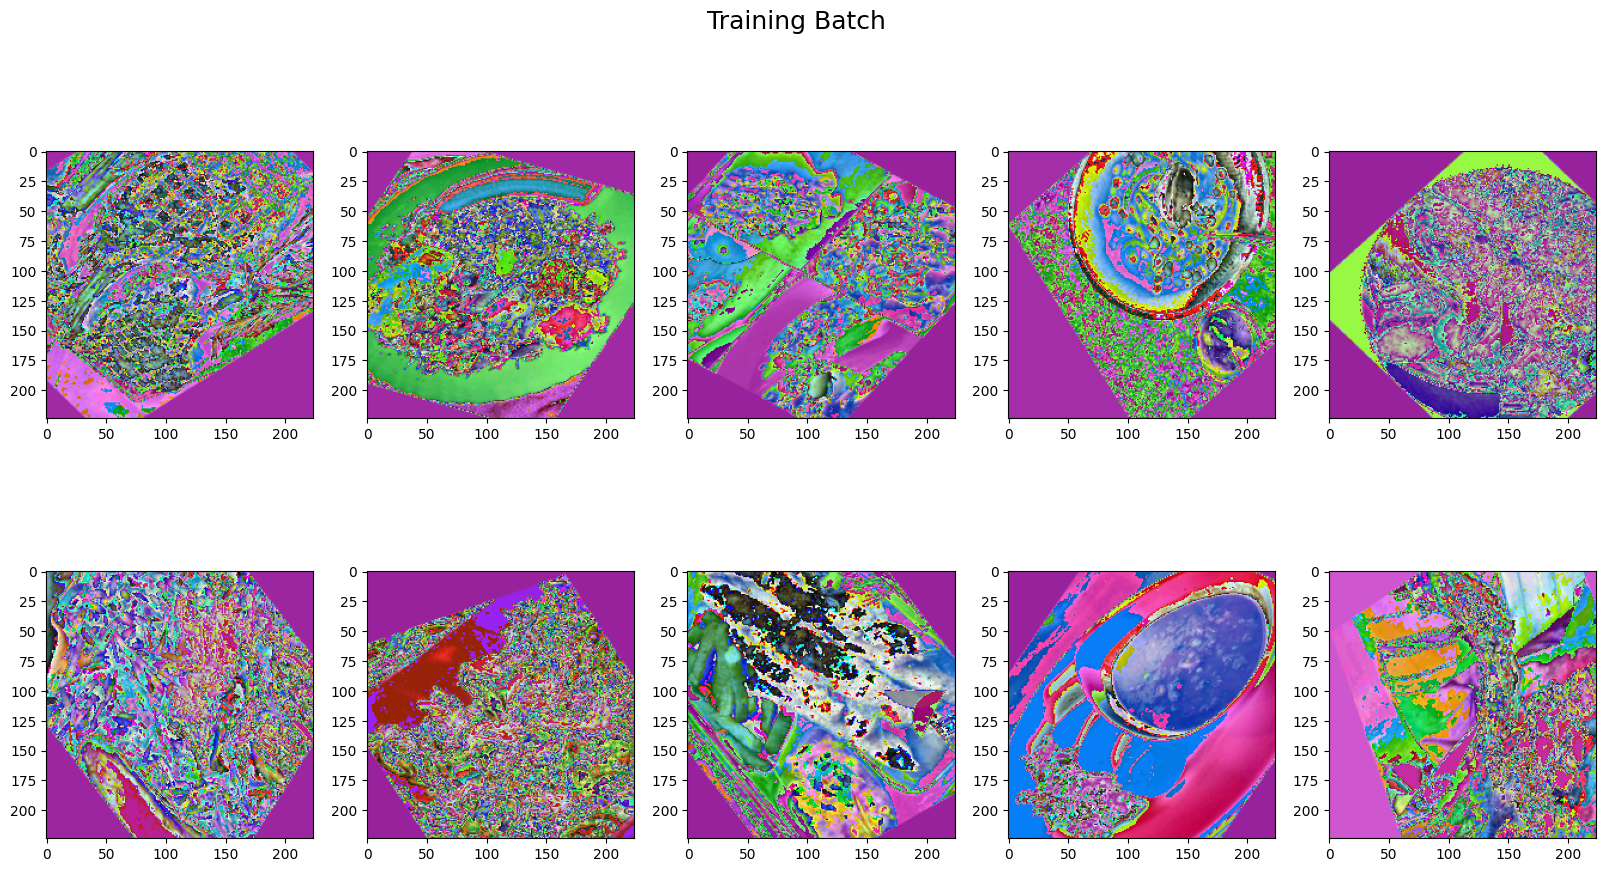

In [9]:
def get_data(data_root, batch_size, num_workers=2, augmentation=False):
    
    dataset = KenyanFood13Dataset(csv_file=r'/kaggle/input/opencv-pytorch-classification-project-2/train.csv',
                                       root_dir=r'/kaggle/input/opencv-pytorch-classification-project-2/images/images',
                                       suffix='.jpg')

    # Used to get the mean and std of the dataset
    
    # mean, std = get_mean_std(dataset)
    
    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5768, 0.4622, 0.3460], [0.2383, 0.2464, 0.2465])
    ])
    
    if augmentation:
        train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomAffine(degrees=60, translate=(0.15, 0.15), shear=20),
            transforms.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.4),
            preprocess
        ])
        print("Data Augmentation is turned ON!")
    else:
        train_transforms = preprocess
    
    # Split into training and validation sets
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    
    # Apply Data Transform
    train_dataset = KenyanFood13Subset(train_dataset, train_transforms)
    test_dataset = KenyanFood13Subset(test_dataset, preprocess)

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, test_loader


#########TEST#######
batch_size = 10
train_loader, test_loader = get_data('/kaggle/input/opencv-pytorch-classification-project-2', batch_size, 2, True)

print('Training Data: {}\nValidation Data: {}'.format(len(train_loader.dataset),len(test_loader.dataset)))

print('Number of classes: {}'.format(len(train_loader.dataset.subset.dataset.data['class'].value_counts())))

print('\nData per class (before split):')
print(train_loader.dataset.subset.dataset.data['class'].value_counts())


piltr = transforms.ToPILImage()

fig = plt.figure(figsize=(20,10))
fig.suptitle('Training Batch', fontsize=18)

for i in range(batch_size):

    img, target = train_loader.dataset[i]
    
    
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(piltr(img))

## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/opencv-pytorch-classification-project-2/" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

In [12]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [10]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 16
    epochs_count: int = 50
    init_learning_rate: float = 0.001  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = r"/kaggle/input/opencv-pytorch-classification-project-2"
    num_workers: int = 6
    device: str = 'cuda'
    input_size = 224
    num_classes = 13

In [13]:
#System Setup

def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [14]:
def trainable_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

In [14]:
class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, 2).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)
        
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()

f1_loss = F1_Loss().cuda()
    

## <font style="color:green">4. Train and Validation [5 Points]</font>


**Write the methods or classes to be used for training and validation.**

In [15]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int, tb_writer: SummaryWriter
) -> None:

    # change model in training mood
    model.train()

    # to get batch loss
    batch_loss = np.array([])

    # to get batch accuracy
    batch_acc = np.array([])

    for batch_idx, (data, target) in enumerate(train_loader):

        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()

        # forward pass to the model
        output = model(data)
        # print(output.size(), 'from train output.size()')
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # loss = Variable(loss, requires_grad = True)
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()

        batch_loss = np.append(batch_loss, [loss.item()])

        # Score to probability using softmax
        prob = F.softmax(output, dim=1)

        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]

        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()

        # accuracy
        acc = float(correct) / float(len(data))

        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:
            
            total_batch = epoch_idx * len(train_loader.dataset)/train_config.batch_size + batch_idx
            tb_writer.add_scalar('Loss/train-batch', loss.item(), total_batch)
            tb_writer.add_scalar('Accuracy/train-batch', acc, total_batch)

    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    tb_writer.add_scalar('Loss/train', epoch_loss.item(), total_batch)
    tb_writer.add_scalar('Accuracy/train', epoch_acc.item(), total_batch)
    
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

In [16]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    #
    model.eval()
    test_loss = 0
    output = None
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)

        target = target.to(train_config.device)

        with torch.no_grad():
            output = model(data)

        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()

        # Score to probability using softmax
        prob = F.softmax(output, dim=1)

        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]

        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)

    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)

    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )

    return test_loss, accuracy/100.0

In [17]:
import time

def main(model, optimizer, tb_writer, scheduler=None, system_configuration=SystemConfiguration(),
         trainingconfiguration=TrainingConfiguration(), augmentation=True):

    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = trainingconfiguration.batch_size
    # num_workers
    num_workers_to_set = trainingconfiguration.num_workers
    # epochs
    epoch_num_to_set = trainingconfiguration.epochs_count

    # if GPU is available use training config,
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=trainingconfiguration.data_root,
        num_workers=num_workers_to_set,
        augmentation=augmentation
    )

    # Update training configuration
    trainingconfiguration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    # send model to device (GPU/CPU)
    model.to(trainingconfiguration.device)

    best_loss = torch.tensor(np.inf)

    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])

    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])

    # Calculate Initial Test Loss
    init_val_loss, init_val_accuracy = validate(trainingconfiguration, model, test_loader)
    print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss,
                                                                                   init_val_accuracy*100))

    # trainig time measurement
    t_begin = time.time()
    for epoch in range(trainingconfiguration.epochs_count):

        # Train
        train_loss, train_acc = train(trainingconfiguration, model, optimizer, train_loader, epoch, tb_writer)

        epoch_train_loss = np.append(epoch_train_loss, [train_loss])

        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * trainingconfiguration.epochs_count - elapsed_time

        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % trainingconfiguration.test_interval == 0:
            current_loss, current_accuracy = validate(trainingconfiguration, model, test_loader)

            epoch_test_loss = np.append(epoch_test_loss, [current_loss])

            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])

            tb_writer.add_scalar('Loss/Validation', current_loss, epoch)
            tb_writer.add_scalar('Accuracy/Validation', current_accuracy, epoch)
            
            # add scalars (loss/accuracy) to tensorboard
            tb_writer.add_scalars('Loss/train-val', {'train': train_loss, 
                                           'validation': current_loss}, epoch)
            tb_writer.add_scalars('Accuracy/train-val', {'train': train_acc, 
                                               'validation': current_accuracy}, epoch)

            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=trainingconfiguration.device)

            # scheduler step/ update learning rate
        if scheduler is not None:
            if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                scheduler.step(current_loss)
                print("Bad Epochs:{}".format(scheduler.num_bad_epochs))
                print("last LR = {}".format(scheduler._last_lr))
            else:
                scheduler.step()


    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))

    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [18]:
def get_optimizer_and_scheduler(model):
    train_config = TrainingConfiguration()

    init_learning_rate = train_config.init_learning_rate

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr = init_learning_rate,
        momentum = 0.9
    )

    factor = 0.5  # reduce by factor 0.5
    patience = 2  # epochs
    threshold = 0.1
    verbose = True
    
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience, verbose=verbose, threshold=threshold)
    
    return optimizer, scheduler

In [19]:
def save_model(model, device, model_dir='models', model_file_name='KenyanFood_classifier_resnet50.pt'):


    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)

    if device == 'cuda':
        model.to('cuda')

    return

## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

In [20]:
def pretrained_resnet50(transfer_learning=True, num_class=13):
    resnet = models.resnet50(pretrained=True)
    
    if transfer_learning:
        for param in resnet.parameters():
            param.requires_grad = True
            
    last_layer_in = resnet.fc.in_features
    resnet.fc = nn.Sequential(
        nn.Linear(last_layer_in, 4096),
        nn.ReLU(),
        nn.Dropout(0.60),
        nn.Linear( 4096,256),
        nn.ReLU(),
        nn.Dropout(0.60),
        nn.Linear(256,num_class)
    )
    
    return resnet

In [21]:
resnet = pretrained_resnet50(num_class=13)
print(resnet)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
# Test
trainable_parameters(pretrained_resnet50(13))

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

In [23]:
optimizer, scheduler = get_optimizer_and_scheduler(resnet)

transfer_learning_sw = SummaryWriter('log_resnet50/transfer_learning')

model, train_loss_exp2, train_acc_exp2, val_loss_exp2, val_acc_exp2 = main(resnet, optimizer, transfer_learning_sw, scheduler, augmentation=True)

transfer_learning_sw.close()

Data Augmentation is turned ON!


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Test set: Average loss: 2.5628, Accuracy: 82/1308 (6%)

Initial Test Loss : 2.562774, 
Initial Test Accuracy : 6.269%

Epoch: 0 
Train Loss: 2.323218 Acc: 0.2340
Elapsed 141.57s, 141.57 s/epoch, 0.43 s/batch, ets 6936.79s

Test set: Average loss: 1.7456, Accuracy: 593/1308 (45%)

Model Improved. Saving the Model...

Bad Epochs:0
last LR = [0.001]
Epoch: 1 
Train Loss: 1.687719 Acc: 0.4639
Elapsed 294.64s, 147.32 s/epoch, 0.45 s/batch, ets 7071.45s

Test set: Average loss: 1.1464, Accuracy: 845/1308 (65%)

Model Improved. Saving the Model...

Bad Epochs:0
last LR = [0.001]
Epoch: 2 
Train Loss: 1.344006 Acc: 0.5891
Elapsed 437.02s, 145.67 s/epoch, 0.45 s/batch, ets 6846.60s

Test set: Average loss: 0.9928, Accuracy: 900/1308 (69%)

Model Improved. Saving the Model...

Bad Epochs:0
last LR = [0.001]
Epoch: 3 
Train Loss: 1.174255 Acc: 0.6329
Elapsed 576.70s, 144.17 s/epoch, 0.44 s/batch, ets 6632.01s

Test set: Average loss: 0.8736, Accuracy: 944/1308 (72%)

Model Improved. Saving the M

In [27]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left',
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()

    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = train_loss[i].min()

        min_val_loss = val_loss[i].min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID LOSS ({0:.4})".format(min_val_loss))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = train_acc[i].max()

        max_val_acc = val_acc[i].max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ACC ({0:.4})".format(max_val_acc))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')

    fig.savefig('sample_loss_acc_plot.png')
    plt.show()

    return

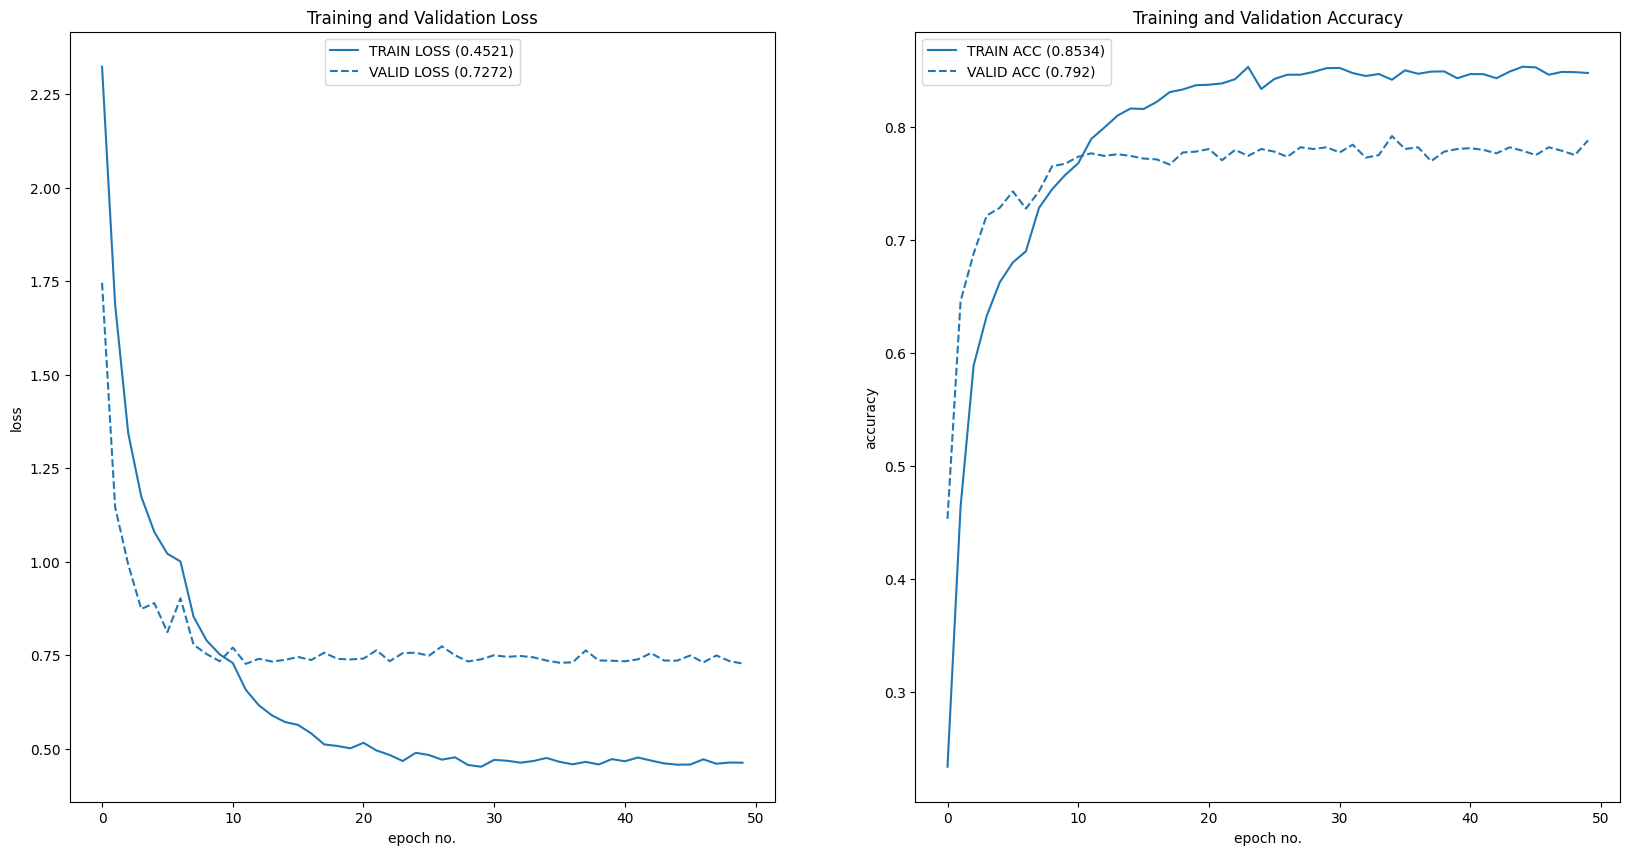

In [28]:
plot_loss_accuracy(train_loss=[train_loss_exp2],
                   val_loss=[val_loss_exp2],
                   train_acc=[train_acc_exp2],
                   val_acc=[val_acc_exp2],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

In [29]:
def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()


def get_results(model, data_root, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        num_workers = 2
        
        
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5768, 0.4622, 0.3460], [0.2383, 0.2464, 0.2465])
        ])
    
    train_dataset =  KenyanFood13Dataset(csv_file=r'/kaggle/input/opencv-pytorch-classification-project-2/train.csv',
                                       root_dir='/kaggle/input/opencv-pytorch-classification-project-2/images/images',
                                       suffix='.jpg', 
                                       transform=transform)

    test_dataset = KenyanFood13Testset(csv_file=r'/kaggle/input/opencv-pytorch-classification-project-2/test.csv',
                                       root_dir=r'/kaggle/input/opencv-pytorch-classification-project-2/images/images',
                                       suffix='.jpg', 
                                       transform=transform)

    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=TrainingConfiguration.num_workers)

    predictions = []
    for data in test_loader:
        cls, prob = prediction(model, device, batch_input=data)
        for target in cls:
            predictions.append(train_dataset.index_to_class(target))

    classes = pd.DataFrame(predictions,columns=['class'])
    result = test_dataset.data.join(classes)
    
    return result

# model = load_model(model)
mean, std = [0.5691, 0.4678, 0.3653], [0.2448, 0.2520, 0.2560]
result = get_results(model, TrainingConfiguration.data_root, mean, std)
result.to_csv('/kaggle/working/submission.csv', index = False, header=True)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

In [ ]:
def save_model(model, device, model_dir='models', model_file_name='KenyanFood_classifier_densenet121_venki.pt'):


    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)

    if device == 'cuda':
        model.to('cuda')

    return

In [ ]:
def pretrained_densenet121_vk(transfer_learning=True, num_class=13):
    model = models.densenet121(pretrained=True)

    if transfer_learning:
        for param in model.parameters():
            param.requires_grad = True

    last_layer_in = model.classifier.in_features
   

    #last_layer_in = model.classifier.in_features
    model.classifier = nn.Linear(last_layer_in, num_class)


    return model

In [ ]:
model = pretrained_densenet121_vk()
print(model)

In [ ]:
# Test
trainable_parameters(pretrained_densenet121_vk(13))

In [ ]:
optimizer,scheduler = get_optimizer_and_scheduler(model)
fine_tuning_sw = SummaryWriter('logs_kenyan_food_densenet121_vk')


model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, fine_tuning_sw, scheduler=scheduler, augmentation=True)

fine_tuning_sw.close()

In [ ]:
plot_loss_accuracy(train_loss=[train_loss],
                   val_loss=[val_loss],
                   train_acc=[train_acc],
                   val_acc=[val_acc],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score , points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**

## <font style="color:green">8. TensorBoard Dev Scalars Log Link [5 Points]</font>

**Share your TensorBoard scalars logs link here You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


For example, [Find Project2 logs here](https://tensorboard.dev/experiment/kMJ4YU0wSNG0IkjrluQ5Dg/#scalars).

In [ ]:
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard
# %reload_ext tensorboard

%tensorboard --logdir=logs_kenyan_food_densenet121_vk/transfer_learning